In [39]:
import os
import importlib  
if not os.path.exists('./bearing-conf-interval'):
  !git clone https://github.com/Gvalhca/bearing-conf-interval.git
mlab_func = importlib.import_module("bearing-conf-interval.plots.mlab_func")

In [55]:
!pip install ipympl
!pip install gdown
!apt install rar -y
from google.colab import output
output.enable_custom_widget_manager()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
rar is already the newest version (2:5.5.0-1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1


In [42]:
import pathlib
pathlib.Path("./data").mkdir(parents=True, exist_ok=True)
!gdown --fuzzy https://drive.google.com/file/d/1dJatTfakPEQJhHPKDPgk6xRCE7fNfxpS/view?usp=sharing
!gdown --fuzzy https://drive.google.com/file/d/1oX408ggrvAWd-AJvlTnzgmt7W25bMjUZ/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1dJatTfakPEQJhHPKDPgk6xRCE7fNfxpS
To: /content/IMS_second_test.rar
100% 165M/165M [00:00<00:00, 261MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oX408ggrvAWd-AJvlTnzgmt7W25bMjUZ
To: /content/PRONOSTIA.rar
100% 191M/191M [00:00<00:00, 209MB/s]


In [51]:
!for rar in ./*.rar; do rar e -y "$rar" ./data/; done


RAR 5.50   Copyright (c) 1993-2017 Alexander Roshal   11 Aug 2017
Trial version             Type 'rar -?' for help


Extracting from ./data/IMS_second_test.rar

Extracting  ./data/2nd_test-4sensor.mat                                    0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 

In [75]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.stats
from typing import Tuple
%matplotlib inline

In [53]:
class BearingPlot:
    def __init__(self, ds_name: str, data_path: str, reb_code='Ax 1_1', sensor_type='S1'):
        ## Initial Parameters
        if dataset_name == 'IMS':
            self.Fs = 20000
            self.N = 20480
            self.t = np.linspace(0, self.N / self.Fs, self.N)
            self.ShaftSpeed = 2000 / 60
            self.BPFI = 8.908 * self.ShaftSpeed
            self.BPFO = 7.092 * self.ShaftSpeed
            self.BSF = 4.197 * self.ShaftSpeed
            self.data_path = os.path.join(data_path, '2nd_test-4sensor.mat')
            # self.data_path = data_path
        else:
            self.Fs = 25600
            self.N = 2560
            self.t = np.linspace(0, 0.1, self.N)
            self.REBcode = reb_code
            self.ShaftSpeed = 1800 / 60
            self.BPFI = 7.389 * self.ShaftSpeed
            self.BPFO = 5.611 * self.ShaftSpeed
            self.BSF = 3.589 * self.ShaftSpeed
            self.data_path = os.path.join(data_path, self.REBcode + '.mat')
            # self.data_path = data_path
        self._load_data()

    def _load_data(self, sensor_type):
        ## Load data
        data_bearing = scipy.io.loadmat(self.data_path)
        
        if dataset_name == 'IMS':
            sensor_type = sensor_type
        else:
            sensor_type = 'ACCx'
        self.VibData = data_bearing[sensor_type]
        self.Life = self.VibData[0, :]
        self.Acc = self.VibData[1:, :]
    
    def draw_signal_plots(self, signal_nums: Tuple):
        ## TDF Calculation and presentation
        # RMS
        RMS = np.sqrt(np.mean(self.Acc ** 2, axis=0))
        fig = plt.figure(1, figsize=(15, 10))
        fig.clear()
        rms_ax = plt.subplot(3, 2, 1)
        plt.ion()
        plt.plot(RMS, 'y')
        plt.grid(True)
        plt.xlabel('Signal Number')
        plt.ylabel('RMS & Peak (g)')

        # Peak
        peak = np.max(np.abs(self.Acc), axis=0)
        plt.plot(peak, 'r')
        plt.grid(True)
        plt.xlabel('Signal Number')
        plt.ylabel('RMS & Peak (g)')
        plt.legend(['RMS', 'Peak'], loc='best', prop={'size': 12})

        # Kurtosis
        kurt = scipy.stats.kurtosis(self.Acc)
        kurt_ax = plt.subplot(3, 2, 3)
        plt.plot(kurt)
        plt.grid(True)
        plt.xlabel('Signal Number')
        plt.ylabel('Kurtosis')

        #Crest Factor
        CF = peak / RMS
        cf_ax = plt.subplot(3, 2, 5)
        plt.plot(CF)
        plt.grid(True)
        plt.xlabel('Signal Number')
        plt.ylabel('CF')

        amplitude_ax = plt.subplot(3, 2, 2)
        spect_gen_ax = plt.subplot(3, 2, 4)
        freq_scaled_ax = plt.subplot(3, 2, 6)

        i = 0
        for x in signal_nums:
            i += 1
            a = int(np.floor(i / 4))
            c = np.abs(2.1 - a)
            b = i - a * 4
            rms_ax.scatter(x, peak[x], color=np.array([1 - b / 4, b / 4, 1 - b / 4]), linewidth=2, zorder=10)
            kurt_ax.scatter(x, kurt[x], color=np.array([1 - b / 4, b / 4, 1 - b / 4]), linewidth=2, zorder=10)
            cf_ax.scatter(x, CF[x], color=np.array([1 - b / 4, b / 4, 1 - b / 4]), linewidth=2, zorder=10)

            ## Time wave and Spectrum presentation
            current_signal = self.Acc[:, x]
            amplitude_ax.plot(self.t, current_signal, color=np.array([1 - b / 4, b / 4, 1 - b / 4]), linewidth=0.5)
            amplitude_ax.grid(True)
            amplitude_ax.set_xlabel('t (s)')
            amplitude_ax.set_ylabel('Amplitude (g)')

            Y, f = mlab_func.spect_gen(current_signal, self.Fs)
            spect_gen_ax.plot(f, Y, color=np.array([1 - b / 4, b / 4, 1 - b / 4]))
            spect_gen_ax.set_title('FFT of Vibration signal')
            spect_gen_ax.set_xlabel('Frequency (Hz)')
            spect_gen_ax.set_ylabel('Amplitude (g)')
            spect_gen_ax.set_xlim(np.array([0, 1000]))

            freq_scaled_ax.plot(f, Y, color=np.array([1 - b / 4, b / 4, 1 - b / 4]))
            freq_scaled_ax.set_title('FFT of Vibration signal')
            freq_scaled_ax.set_xlabel('Frequency (Hz)')
            freq_scaled_ax.set_ylabel('Amplitude (g)')
            freq_scaled_ax.grid(True)
            freq_scaled_ax.set_xlim(np.array([0, self.Fs / 2.5]))

            #Plot the characteristic frequencies
            x_bounds = spect_gen_ax.get_xlim()
            spect_gen_ax.axvline(self.BPFI, c='y', ls='--', label='BPFI')
            spect_gen_ax.annotate(s='BPFI', xy=(((self.BPFI - x_bounds[0]) / (x_bounds[1] - x_bounds[0])), 1.01),
                                  xycoords='axes fraction', verticalalignment='top', horizontalalignment='left', rotation=270,
                                  fontsize=12, color='y')
            spect_gen_ax.axvline(2 * self.BPFI, c='y', ls='--', label='2xBPFI')
            spect_gen_ax.annotate(s='2xBPFI', xy=(((2 * self.BPFI - x_bounds[0]) / (x_bounds[1] - x_bounds[0])), 1.01),
                                  xycoords='axes fraction', verticalalignment='top', horizontalalignment='left', rotation=270,
                                  fontsize=12, color='y')
            spect_gen_ax.axvline(3 * self.BPFI, c='y', ls='--', label='3xBPFI')
            spect_gen_ax.annotate(s='3xBPFI', xy=(((3 * self.BPFI - x_bounds[0]) / (x_bounds[1] - x_bounds[0])), 1.01),
                                  xycoords='axes fraction', verticalalignment='top', horizontalalignment='left', rotation=270,
                                  fontsize=12, color='y')
            spect_gen_ax.axvline(self.BSF, c='g', ls='--', label='BSF')
            spect_gen_ax.annotate(s='BSF', xy=(((self.BSF - x_bounds[0]) / (x_bounds[1] - x_bounds[0])), 1.01),
                                  xycoords='axes fraction', verticalalignment='top', horizontalalignment='left', rotation=270,
                                  fontsize=12, color='g')
            spect_gen_ax.axvline(2 * self.BSF, c='g', ls='--', label='2xBSF')
            spect_gen_ax.annotate(s='2xBSF', xy=(((2 * self.BSF - x_bounds[0]) / (x_bounds[1] - x_bounds[0])), 1.01),
                                  xycoords='axes fraction', verticalalignment='top', horizontalalignment='left', rotation=270,
                                  fontsize=12, color='g')
            spect_gen_ax.axvline(3 * self.BSF, c='g', ls='--', label='3xBSF')
            spect_gen_ax.annotate(s='3xBSF', xy=(((3 * self.BSF - x_bounds[0]) / (x_bounds[1] - x_bounds[0])), 1.01),
                                  xycoords='axes fraction', verticalalignment='top', horizontalalignment='left', rotation=270,
                                  fontsize=12, color='g')
            spect_gen_ax.axvline(self.BPFO, c='r', ls='--', label='BPFO')
            spect_gen_ax.annotate(s='BPFO', xy=(((self.BPFO - x_bounds[0]) / (x_bounds[1] - x_bounds[0])), 1.01),
                                  xycoords='axes fraction', verticalalignment='top', horizontalalignment='left', rotation=270,
                                  fontsize=12, color='r')
            spect_gen_ax.axvline(2 * self.BPFO, c='r', ls='--', label='2xBPFO')
            spect_gen_ax.annotate(s='2xBPFO', xy=(((2 * self.BPFO - x_bounds[0]) / (x_bounds[1] - x_bounds[0])), 1.01),
                                  xycoords='axes fraction', verticalalignment='top', horizontalalignment='left', rotation=270,
                                  fontsize=12, color='r')
            spect_gen_ax.axvline(3 * self.BPFO, c='r', ls='--', label='3xBPFO')
            spect_gen_ax.annotate(s='3xBPFO', xy=(((3 * self.BPFO - x_bounds[0]) / (x_bounds[1] - x_bounds[0])), 1.01),
                                  xycoords='axes fraction', verticalalignment='top', horizontalalignment='left', rotation=270,
                                  fontsize=12, color='r')

        legends = ['RMS', 'Peak'] + list(signal_nums)
        rms_ax.legend(legends)
        fig.tight_layout()
        plt.show()

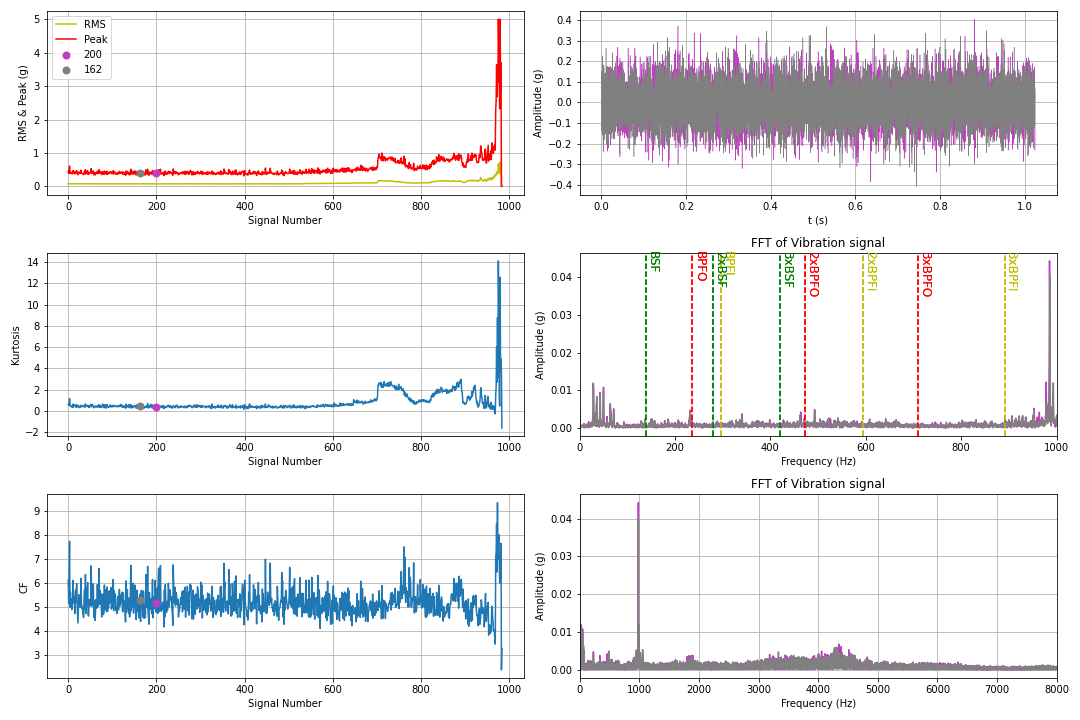

In [79]:
dataset_name = 'IMS'  #@param ['IMS', 'PRONOSTIA']
data_path = '/content/data/' #@param {type:"string"}
# data_path = '/content/data/Pronostia data/Ax 1_1.mat'

if dataset_name == 'PRONOSTIA':
  #@markdown ---
  #@markdown ##### Name of PRONOSTIA .mat file:
  reb_code = 'Ax 2_7' #@param {type:"string"}
  sensor_type = None
else:
  reb_code = None
  #@markdown ---
  #@markdown ##### Sensor type in IMS set:
  sensor_type = 'S1' #@param ['S1', 'S2', 'S3', 'S4']
#@markdown ---
#@markdown ### Enter signal numbers, e.g. (0, 10, 100, 200,):
# signals = (0, 10, 100, 200, 500, 750)
signals = (100, 200) #@param {type:"raw"}

bearing_plot = BearingPlot(ds_name=dataset_name, data_path=data_path, reb_code=reb_code)
bearing_plot.draw_signal_plots(signals)